# Dependencies

In [222]:
import pandas as pd              #package for data analysis
import numpy as np               #package for handling numpy arrays
import seaborn as sns            #package for data visualization
import matplotlib.pyplot as plt  #package for data visualization
from collections import Counter  #to count occurence of specific terms in the text
import neattext as nt            #package for text cleaning
import warnings                  #package of ingoring warnings
from textblob import TextBlob    #package for sentiment analysis of short sentences
import spacy                     #package for text analysis
from wordcloud import WordCloud  #package for word cloud
warnings.filterwarnings('ignore')#filter out all the warnings
import json   #package for handling json data
import glob   #return all file paths that match a specific pattern
#Gensim for topic modeling
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


# Reading the Data

In [224]:
complete_df=pd.read_excel("Bookingcom_7367_comments.xlsx")

# English Translation

In [225]:
from googletrans import Translator  #google api for language translation
translator = Translator()           #initializing translator

In [226]:
def to_eng_translation(comment):
    translation = translator.translate(comment, dest="en")   #converting text to english
    return translation.text

### Removing Emoji so that Text can Translated

In [228]:
df=complete_df[0:50]  #getting a sample of complete data

In [229]:
df['Cleaned_Data']=df['comment'].apply(lambda x:nt.remove_emojis(x))

In [230]:
df['Translated_Text']=df['Cleaned_Data'].apply(lambda x:to_eng_translation(x))

# Top 10 Commentors

findfont: Font family ['Droid Sans Japanese'] not found. Falling back to DejaVu Sans.


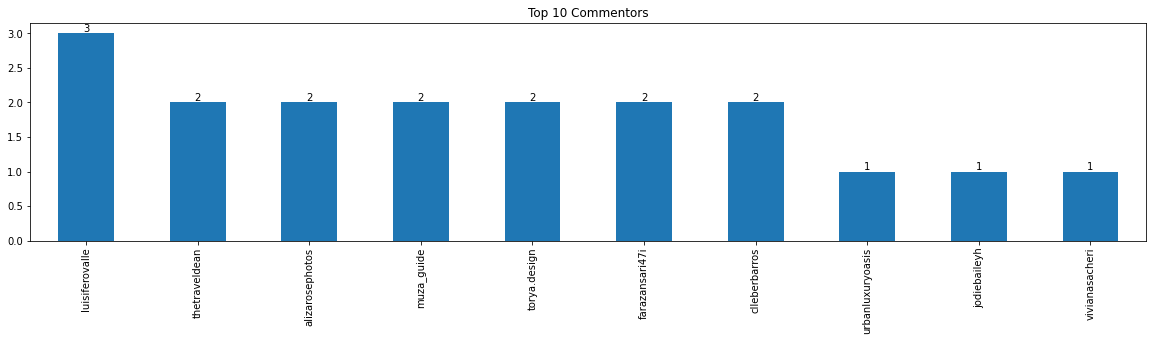

In [231]:
fig,ax = plt.subplots(figsize=(20,4))   #defining the fig size
df['commentor'].value_counts().sort_values(ascending=False)[0:10].plot(kind = 'bar')  #creating bar from top 10 values
for container in ax.containers:   #code for creating labeling bar of the bar chart
    ax.bar_label(container)
ax.set(title="Top 10 Commentors")
plt.show()

# Emojis Used By Commentors

In [233]:
import emoji   #package for emoji extraction
emojis=[]
for message in df['comment']:
    emojis.extend([emoji_code for emoji_code in message if emoji_code in emoji.UNICODE_EMOJI['en']]) #finding emojis
    emoji_df=pd.DataFrame(Counter(emojis).most_common(20))    #creating dataframe of top 20 emojis
    emoji_df.columns=['Emoji','Frequency']

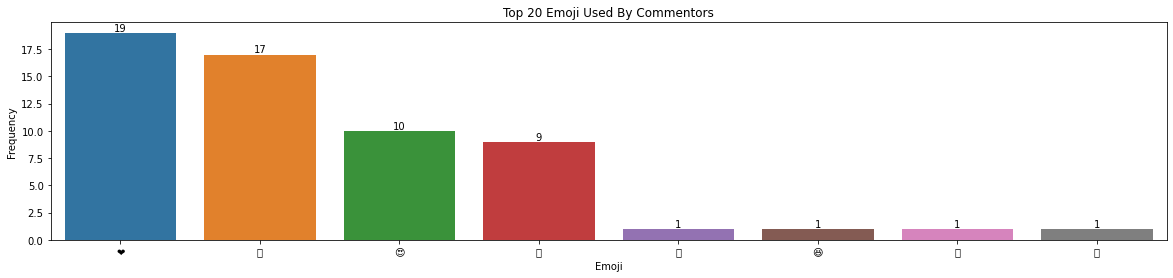

In [234]:
fig,ax = plt.subplots(figsize=(20,4))   
sns.barplot(x="Emoji", y="Frequency", data=emoji_df)
for container in ax.containers:
    ax.bar_label(container)
ax.set(title="Top 20 Emoji Used By Commentors")
plt.show()

# Text Metrics

In [235]:
comments=' '.join(df['Translated_Text'])   #confining all the comment in comments variable

In [236]:
from neattext import TextMetrics    #importing textmetrics from neattext
docx = TextMetrics()
docx.text = comments
docx.word_stats()              #displaying the word statistics

{'text_length': 8251,
 'num_of_vowels': 2494,
 'num_of_consonants': 3900,
 'num_of_stopwords': 832,
 'vowels_stats': {'a': 513, 'e': 796, 'i': 415, 'o': 578, 'u': 192},
 'consonants_stats': {'b': 130,
  'c': 205,
  'd': 231,
  'f': 89,
  'g': 119,
  'h': 305,
  'j': 19,
  'k': 79,
  'l': 258,
  'm': 219,
  'n': 441,
  'p': 108,
  'q': 3,
  'r': 359,
  's': 322,
  't': 548,
  'v': 89,
  'w': 152,
  'x': 9,
  'y': 206,
  'z': 9}}

# Parts of Speech Counts

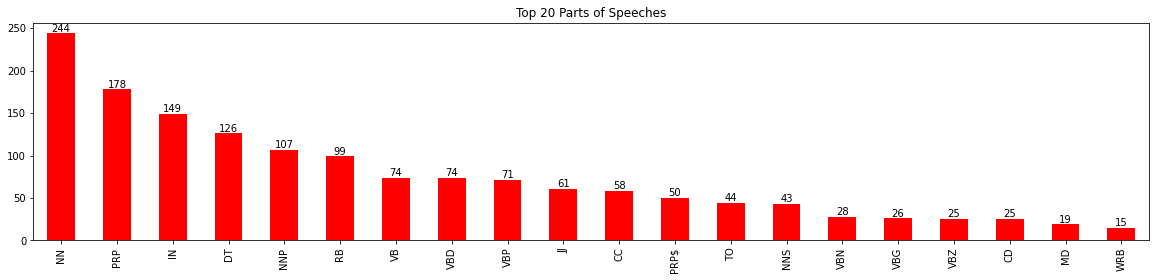

In [237]:
fig,ax = plt.subplots(figsize=(20,4))  #define figure size
blob = TextBlob(str(comments))   #comments variable contains all the comments
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.plot(kind = 'bar',color='red')
for container in ax.containers:
    ax.bar_label(container)
plt.title("Top 20 Parts of Speeches")
plt.show()

In [238]:
#Create a function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [239]:
df['polarity']=df['Translated_Text'].apply(lambda x:getPolarity(x))

# Polarity Ranges

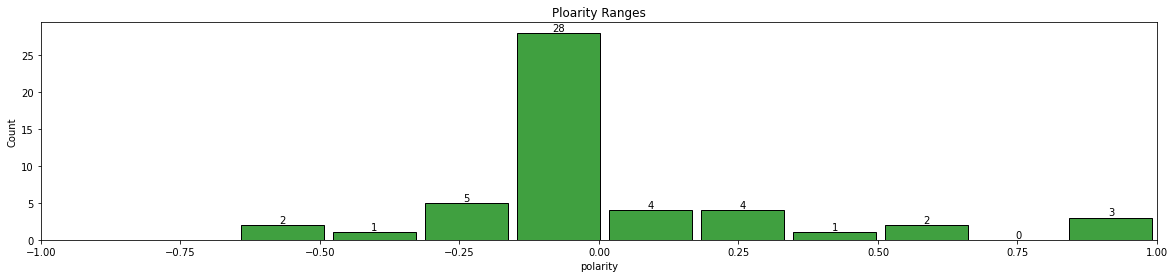

In [241]:
fig,ax = plt.subplots(figsize=(20,4))
sns.histplot(data=df, x='polarity',shrink=.9,bins=10,color='green')
ax.set(xlim=(-1, 1))
for container in ax.containers:
    ax.bar_label(container)
ax.set(title="Ploarity Ranges")
plt.show()

# Polarity Distribution

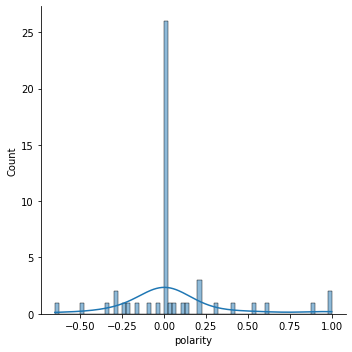

In [242]:
sns.displot(df, x="polarity", kde=True)
plt.show()

In [243]:
def getSentimentTag(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [244]:
df['sentiment']=df['polarity'].apply(lambda x:getSentimentTag(x))

# Sentiments

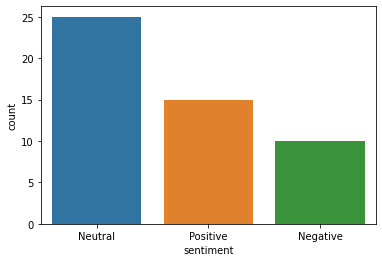

In [245]:
sns.countplot(df['sentiment'])
plt.show()

# Topic Modeling

# Text Cleaning

# Removing Stopwords

In [248]:
df['Translated_Text']=df['Translated_Text'].apply(lambda x:nt.remove_stopwords(str(x)))

# Removing Special Characters

In [249]:
df['Translated_Text']=df['Translated_Text'].apply(lambda x:nt.remove_special_characters(str(x)))

# Removing Numbers

In [250]:
df['Translated_Text']=df['Translated_Text'].apply(lambda x:nt.remove_numbers(str(x)))

# Fixing Contractions => don't -> do not

In [251]:
df['Translated_Text']=df['Translated_Text'].apply(lambda x:nt.fix_contractions(x))

# Removing Mentions

In [252]:
df['Translated_Text']=df['Translated_Text'].apply(lambda x:re.sub("@([a-zA-Z0-9_]{1,50})","",x))

# Removing Hastags

In [253]:
df['Translated_Text']=df['Translated_Text'].apply(lambda x:re.sub("#([a-zA-Z0-9_]{1,50})","",x))

In [254]:
import string   #package for string handling
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation}  #removing punctuation
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if(not w.isdigit()and(not w.isdigit()and len(w)>3))]) #getting words greater than len 3 
    return text2.lower()

In [255]:
df['Translated_Text']=df['Translated_Text'].apply(lambda x:clean_text(str(x)))

# Getting Nouns and Adjective from the Text

In [256]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
    output = []
    for sent in texts:
        doc = nlp(sent) 
        output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
    return output

In [257]:
text_list=df['Translated_Text'].tolist()

In [159]:
tokenized_comments = lemmatization(text_list)

# Training LDA

In [ ]:
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

In [ ]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=20, random_state=100,
                chunksize=1000, passes=50,iterations=100)

# Getting Topic

In [ ]:
topics=lda_model.print_topics()

In [ ]:
topics

# Word Cloud for Topics

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# LDA Co-occcurence Term Analysis

In [ ]:
lda_df=pd.DataFrame(topics)   #converting extracted topics to dataframe
lda_df.columns=['cnt','word'] #assigning feature names to the dataframe

In [ ]:
lda_df['word']=lda_df['word'].apply(lambda x:' '.join([i[0] for i in x]))  #getting topic words

In [ ]:
lda_df['word']=lda_df['word'].apply(lambda x:''.join(str(x).split()[0]))   #gettind single word

In [ ]:
vocab = {}
target_words = lda_df[lda_df['cnt'] > 1]['word'].to_numpy()
for word in target_words:
    if word not in vocab:
        vocab[word] = len(vocab)

re_vocab = {}
for word, i in vocab.items():
    re_vocab[i] = word
    
len(vocab)

In [ ]:
comment_words=''.join(lda_df['word'])   #confining all the words in comment_words variable

In [ ]:
import itertools
tweet_combinations = [list(itertools.combinations(words, 2)) for words in comment_words]
combination_matrix = np.zeros((len(vocab), len(vocab)))

for tweet_comb in tweet_combinations:
    for comb in tweet_comb:
        if comb[0] in target_words and comb[1] in target_words:
            combination_matrix[vocab[comb[0]], vocab[comb[1]]] += 1
            combination_matrix[vocab[comb[1]], vocab[comb[0]]] += 1
        
for i in range(len(vocab)):
    combination_matrix[i, i] /= 2
        
combination_matrix

In [ ]:
import networkx as nx        #package for creating co-occurence network
from scipy.spatial import distance  #import package to calculate distanc b/w nodes

In [ ]:
jaccard_matrix = 1 - distance.cdist(combination_matrix, combination_matrix, 'jaccard')  #creating distance matrix
jaccard_matrix

In [ ]:
import collections
word_cnt = collections.Counter(comment_words.split())    #counting occurences of words

### Calculating Node Distances

In [ ]:
nodes = []
for i in range(len(vocab)):
    for j in range(i+1, len(vocab)):
        jaccard = jaccard_matrix[i, j]
        if jaccard > 0:
            nodes.append([re_vocab[i], re_vocab[j], word_cnt[re_vocab[i]], word_cnt[re_vocab[j]], jaccard])
            

# Drawing Co-occurence Graph

In [ ]:
G = nx.Graph()
G.nodes(data=True)

for pair in nodes:
    node_x, node_y, node_x_cnt, node_y_cnt, jaccard = pair[0], pair[1], pair[2], pair[3], pair[4]
    if not G.has_node(node_x):
        G.add_node(node_x, count=node_x_cnt)
    if not G.has_node(node_y):
        G.add_node(node_y, count=node_y_cnt)
    if not G.has_edge(node_x, node_y):
        G.add_edge(node_x, node_y, weight=jaccard)
        
plt.figure(figsize=(15,15))
pos = nx.spring_layout(G, k=0.1)

node_size = [d['count']*100 for (n,d) in G.nodes(data=True)]
nx.draw_networkx_nodes(G, pos, node_color='cyan', alpha=1.0, node_size=node_size)
nx.draw_networkx_labels(G, pos,  font_family='Droid Sans Japanese')

edge_width = [d['weight']*10 for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='black', width=edge_width)

plt.axis('off')
plt.show()

# Term Frequency Analysis

In [ ]:
# natural language processing: n-gram ranking
import re          #for finding the patterns of data
import unicodedata  #for dealing with unicode data
import nltk   #package for text handling

# Bigrams

In [ ]:
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:20]

# Bigram Visualization

In [ ]:
bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

# Trigrams

In [ ]:
trigrams_series = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:20]

# Trigram Visualization

In [ ]:
trigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Trigrams')
plt.ylabel('Trigrams')
plt.xlabel('# of Occurances')